#### Práctica 2: Tipología y ciclo de vida de los datos
# Análisis sobre enfermedades cardiacas
#### Autores: 
- Víctor H. Ayala Sánchez  
- Clara M. Roca de la Concha

https://archive.ics.uci.edu/ml/datasets/heart+disease

# Tabla de contenidos

- 1. [Descripción del dataset](#1.-Descripción-del-dataset)
- 2. [Integración y selección de los datos de interés a analizar](#2.-Integración-y-selección-de-los-datos-de-interés-a-analizar)
- 3. [Limpieza de los datos](#3.-Limpieza-de-los-datos)
    - 3.1. [¿Los datos contienen ceros o elementos vacíos?](#3.1.-¿Los-datos-contienen-ceros-o-elementos-vacíos?)
    - 3.2. [Identifica y gestiona los valores extremos](#3.2.-Identifica-y-gestiona-los-valores-extremos)
- 4.[Análisis de los datos](#4.-Análisis-de-los-datos)
    - 4.1.[Selección de los grupos de datos que se quieren analizar/comparar](#4.1.-Selección-de-los-grupos-de-datos-que-se-quieren-analizar/comparar)
    - 4.2.[Comprobación de la normalidad y homogeneidad de la varianza](#4.2.-Comprobación-de-la-normalidad-y-homogeneidad-de-la-varianza)
    - 4.3.[Aplicación de pruebas estadísticas para comparar los grupos de datos](#4.3.-Aplicación-de-pruebas-estadísticas-para-comparar-los-grupos-de-datos)
    - 4.4.[Relación entre predictores](#4.4.-Relación-entre-predictores)
    - 4.5 [Modelaje Estadístico](#4.4.-Modelaje-Estadístico)
- 5.[Representación gráfica](#5.-Representación-gráfica)
- 6.[Resolución del problema](#6.-Resolución-del-problema)
- 7.[Código](#7.-Código)
- 8.[Vídeo](#8.-Vídeo)
- [Contribuciones](#Contribuciones)

# Librerías

In [81]:
import pandas as pd
import numpy as np
from scipy.stats import levene


import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


# 1. Descripción del dataset

**¿Por qué es importante y qué pregunta/problema pretende responder?**			

Partimos del dataset recomendado por la asignatura: [*Heart Attack Analysis & Prediction dataset*](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset). En principio, este dataset trata de explicar la enfermedad cardiaca a partir de una serie de factores, como el colesterol o la frecuencia cardiaca. No obstante, aclararemos que este dataset es útil para practicar, pero no tanto para resolver un problema real, tal como ya se comenta [en el foro del propio dataset en Kaggle](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset/discussion/249239). 

En un análisis preliminar de los datos, podemos comprobar que el archivo `heart.csv` consta de 303 registros y 14 variables. La información de Kaggle es escasa, puesto que no proporciona información espacio-temporal sobre los datos. Tampoco proporciona citas adicionales sobre las fuentes, siendo que es improbable que los que proporcionan este dataset sean los autores de la investigación. Nótese que señalan la procedencia 'online' y el método 'crawling'. 

Una búsqueda rápida nos llevará a encontrar [el origen de los datos](https://archive.ics.uci.edu/ml/datasets/heart+disease). Se trata de un popular dataset donado en 1988. El estudio original consta de 4 ubicaciones:
1. Budapest (Hungría): Hungarian Institute of Cardiology, Andras Janosi, M.D.
2. Zurich (Suiza): University Hospital, William Steinbrunn, M.D.
3. Basilea (Suiza): University Hospital, Matthias Pfisterer, M.D.
4. Cleveland (Estados Unidos): V.A. Medical Center, Long Beach and Cleveland Clinic Foundation, Robert Detrano, M.D., Ph.D.

Originalmente, constaba de 76 atributos, si bien "todos los experimentos publicados se refieren a 14 atributos", tal como se nos indica [en el repositorio original](https://archive.ics.uci.edu/ml/datasets/heart+disease). Los datos compartidos en Kaggle proceden del dataset de Cleveland, el más popular en los estudios de Machine Learning. 

Por lo tanto, tenemos en nuestras manos un dataset cuya fuente original no está citada, con un número de registros menor al ideal en un estudio de estas características y de una antigüedad considerable. Presenta además algunas dificultades, como el hecho de que algunos valores no se corresponden con los establecidos en la descripción de los datos. Por ejemplo, la variable `cp` ('chest pain type') va del 0 al 3 mientras que en la descripción –tanto en kaggle como en el repositorio de UCI– va del 1 al 4. Instuitivamente cabe pensar que el 1 original pasó al 0 y el 4, al 3. Sin embargo, comparando los datos de Kaggle con el dataset original, podemos comprobar que esto no es así. Otros valores hacen saltar las alarmas, como la asignación en la variable `output`. Por este motivo, hemos tomado la decisión de partir directamente del dataset original, que se encuentra [aquí](https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/) bajo el nombre `processed.cleveland.data`.

Dicho esto, pasamos a describir las variables que tenemos entre manos:

`age`: edad del paciente

`sex`: sexo del paciente

        0 = mujer
        1 = hombre
        
        
`cp`: tipo de dolor de pecho. 

        1 = angina típica
        2 = angina atípica
        3 = dolor no anginoso
        4 = asintomático
        
`trestbps` : presión sanguínea en reposo (en mm Hg)

`chol` : colesterol en mg/dl

`fbs` : azúcar en sangre en ayunas > 120 mg/dl.

        0 = falso
        1 = verdadero
        
`restecg` : resultados electrocardiográficos en reposo

        0 = normal
        1 = anomalías en la onda ST-T
        2 = hipertrofia ventricular izquierda
        
`thalach` : frecuencia cardiaca máxima alcanzada.

`exang`: angina inducida por el ejercicio

        0 = no
        1 = sí
        
`oldpeak`: depresión del ST inducida por el ejercicio en relación con el reposo

`slope`: la pendiente del segmento ST de ejercicio máximo.

        1 = pendiente ascendiente 
        2 = sin pendiente
        3 = pendiente descendente
        
`ca`: número de vasos principales (de 0 a 3)

`thal`: Thallium Stress Test, por lo que podemos leer [aquí](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset/discussion/234843?sort=votes)

        3 = normal
        6 = defecto arreglado
        7 = defecto reversible 

`num`: atributo predicho; diagnóstico de enfermedad cardíaca (estado de enfermedad angiográfico)

        0 = ausencia de enfermedad cardíaca
        1, 2, 3 o 4 = presencia de enfermedad cardíaca

# 2. Integración y selección de los datos de interés a analizar
**Puede ser el resultado de adicionar diferentes datasets o una subselección útil de los datos originales, en base al objetivo que se quiera conseguir.**

Usaremos el dataset al completo, teniendo en cuenta que ya se parte de una reducción del original, que contenía 76 variables, si bien sí realizaremos ciertas modificaciones que pasamos a describir aquí:

1. Añadimos el nombre de las columnas, no presente en el archivo.
2. Convertimos los valores de ciertas variables para unificar las categorías de 'normal' o 'asintomático' en 0:
    a. `cp`:
        
        0 = asintomático (antes 4)
        1 = angina típica
        2 = angina atípica
        3 = dolor no anginoso
        
    b. `thal`:
    
        0 = normal (antes 3)
        1 = defecto arreglado (antes 6)
        2 = defecto reversible (antes 7)

3. Unificamos todos los resultados en `num` de presencia de enfermedad cardíaca en 1 para que quede:
    
        0 = ausencia de enfermedad cardíaca
        1 = presencia de enfermedad cardíaca
        
Antes de realizar todos estos cambios, deberemos asegurarnos de que no haya algún valor nulo imputado con estos números.   

In [2]:
# Añadimos al dataset el nombre correspondiente de cada columna
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 
           'fbs', 'restecg', 'thalach', 'exang', 
           'oldpeak', 'slope', 'ca', 'thal', 'num']
df = pd.read_csv("data/processed.cleveland.csv", header=None, names=columns)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  num       303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB


Vamos a homogeneizar el dataframe y pasar todo a numeric. Usaremos `errors='coerce'` para convertir en nulos los valores no numéricos.

In [4]:
df = df.apply(pd.to_numeric, errors='coerce')

A continuación, podemos comprobar que, efectivamente, `ca`contiene 4 valores nulos y `thal`, 2.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB


Hecho esto, analizaremos el resumen estadístico para comprobar que todas las variables se encuentran en los rangos correctos.

In [6]:
df.describe(include = 'all')

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


Visto que, efectivamente, todas las variables se ajustan a lo indicado en la descripción del dataset, procedemos a recodificar las variables indicadas.

In [7]:
df = df.replace({
    'cp': {
        4: 0
        },
   
    'thal':{ 
        3 : 0,
        6 : 1,
        7 : 2
    },
    
    'num':{ 
        2 : 1,
        3 : 1,
        4 : 1
    }  
    
})
        
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,1.257426,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,0.837209,0.458746
std,9.038662,0.467299,1.309568,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,0.957468,0.499120
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,0.000000,0.000000
75%,61.000000,1.000000,3.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,2.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,2.000000,1.000000


# 3. Limpieza de los datos

## 3.1. ¿Los datos contienen ceros o elementos vacíos? 
**Gestiona cada uno de estos casos.**

Como ya hemos podido comprobar, existen valores nulos en la variable `ca`y en la variable `thal`.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB


Realizamos un preprocesamiento, haciendo replace sobre las variables categóricas para poder analizar los datos

In [9]:
df = df.replace({
    'cp': {
        0: 'typical angina',
        1: 'atypical angina',
        2: 'non-anginal pain',
        3: 'asymptomatic'
        },
    'sex':{
        1:'Male',
        0:'Female'
    },
    'restecg':{
        0:'Normal',
        1:'ST-T wave abnormality',
        2:'Left ventricular hypertrophy'
    },
    'exng':{
        0:'Yes Angina',
        1:'No Angina'
    },
    'fbs':{
        0:'fastingBloodSugar_false',
        1:'fastingBloodSugar_true'  
    },
    'slp':{
        0:'upsloping',
        1:'flat',
        2:'downsloping'
    },
    'thall':{ 
        0 : np.NaN,
        1 : "fixed defect",
        2 : "normal",
        3 : "reversable defect"
    }
    
})

df.sample(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
245,67.0,Male,typical angina,120.0,237.0,fastingBloodSugar_false,Normal,71.0,0.0,1.0,2.0,0.0,0.0,1
249,62.0,Male,non-anginal pain,128.0,208.0,fastingBloodSugar_true,Left ventricular hypertrophy,140.0,0.0,0.0,1.0,0.0,0.0,0
105,54.0,Male,non-anginal pain,108.0,309.0,fastingBloodSugar_false,Normal,156.0,0.0,0.0,1.0,0.0,2.0,0
55,54.0,Male,typical angina,124.0,266.0,fastingBloodSugar_false,Left ventricular hypertrophy,109.0,1.0,2.2,2.0,1.0,2.0,1
30,69.0,Female,atypical angina,140.0,239.0,fastingBloodSugar_false,Normal,151.0,0.0,1.8,1.0,2.0,0.0,0
263,44.0,Male,asymptomatic,120.0,226.0,fastingBloodSugar_false,Normal,169.0,0.0,0.0,1.0,0.0,0.0,0
230,52.0,Female,asymptomatic,136.0,196.0,fastingBloodSugar_false,Left ventricular hypertrophy,169.0,0.0,0.1,2.0,0.0,0.0,0
136,70.0,Male,typical angina,145.0,174.0,fastingBloodSugar_false,Normal,125.0,1.0,2.6,3.0,0.0,2.0,1
294,63.0,Female,typical angina,124.0,197.0,fastingBloodSugar_false,Normal,136.0,1.0,0.0,2.0,0.0,0.0,1
212,41.0,Male,asymptomatic,130.0,214.0,fastingBloodSugar_false,Left ventricular hypertrophy,168.0,0.0,2.0,2.0,0.0,0.0,0


Una vez realizado el proceso de replace podemos notar que tenemos dos registros con valores aunsentes o perdidos en la variable **thall**

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    object 
 2   cp        303 non-null    object 
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    object 
 6   restecg   303 non-null    object 
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    object 
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    object 
 11  caa       303 non-null    int64  
 12  thall     301 non-null    object 
 13  output    303 non-null    int64  
dtypes: float64(1), int64(6), object(7)
memory usage: 33.3+ KB


Considerando que son solo 2 registros y que representan menos del 1% de los datos decidimos directamente eliminarlos del conjunto de datos. 

In [43]:
df.dropna(inplace=True)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       301 non-null    int64  
 1   sex       301 non-null    object 
 2   cp        301 non-null    object 
 3   trtbps    301 non-null    int64  
 4   chol      301 non-null    int64  
 5   fbs       301 non-null    object 
 6   restecg   301 non-null    object 
 7   thalachh  301 non-null    int64  
 8   exng      301 non-null    object 
 9   oldpeak   301 non-null    float64
 10  slp       301 non-null    object 
 11  caa       301 non-null    int64  
 12  thall     301 non-null    object 
 13  output    301 non-null    int64  
dtypes: float64(1), int64(6), object(7)
memory usage: 35.3+ KB


## 3.2. Identifica y gestiona los valores extremos
**Escribir aquí la solución.**


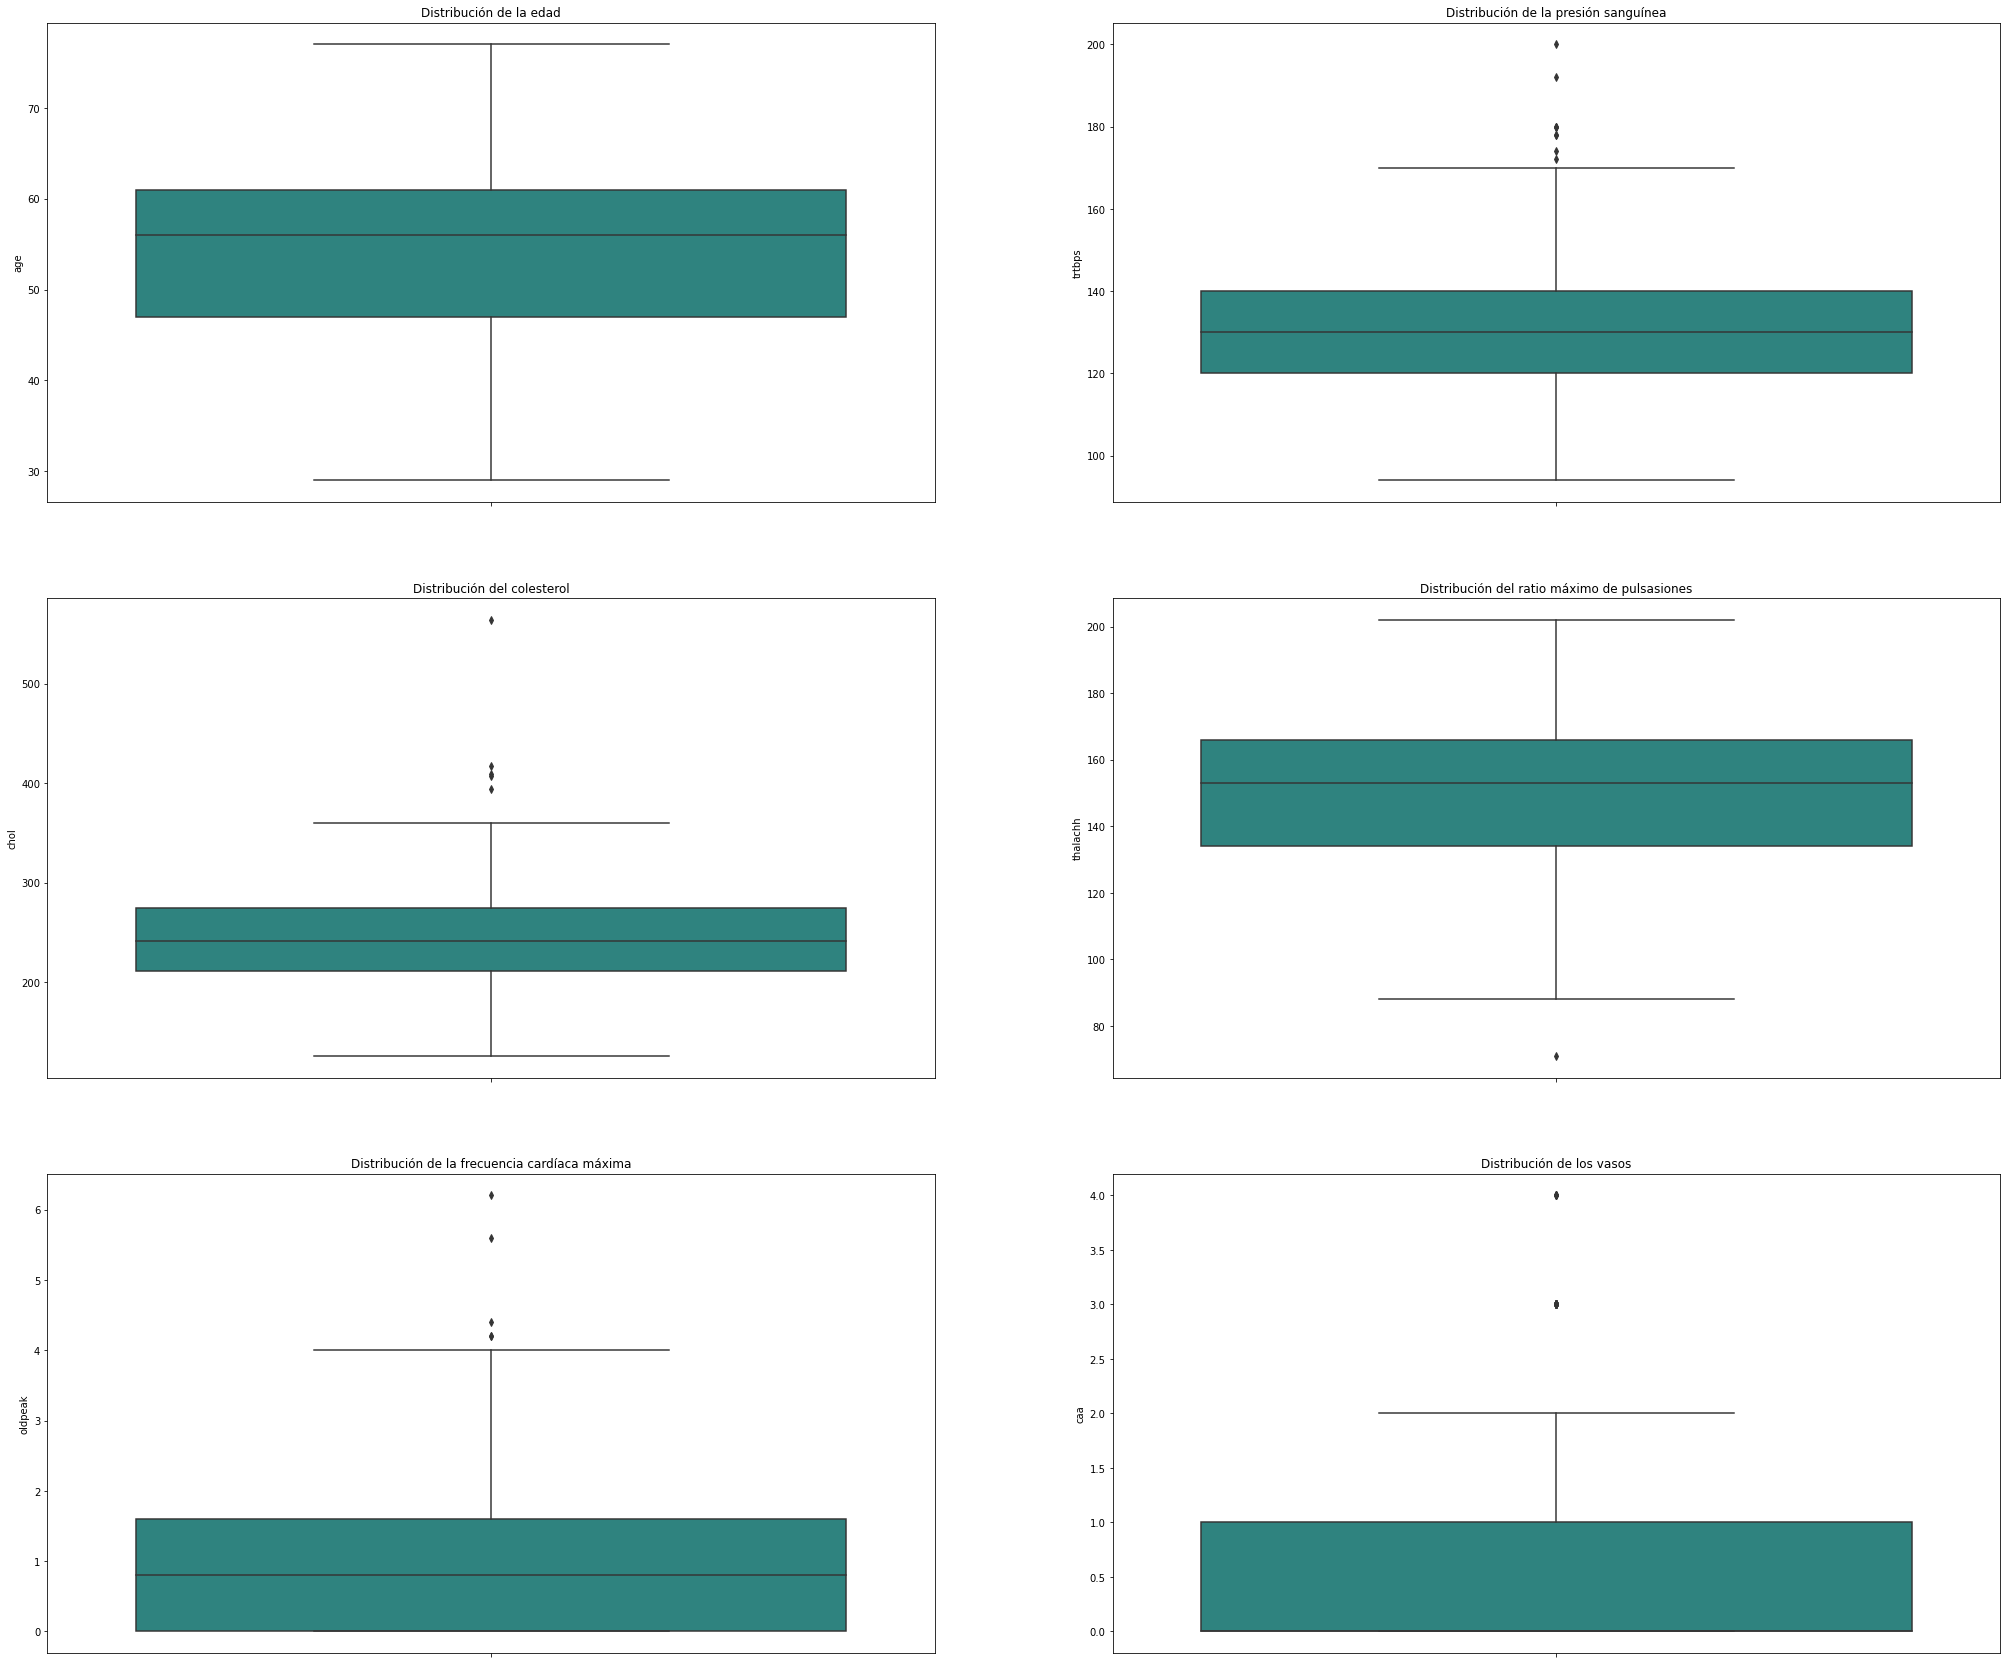

In [57]:
fig, axes = plt.subplots(3, 2, figsize=(35,30))

sns.boxplot(ax=axes[0,0], y="age", palette="viridis", data=df).set(title='Distribución de la edad')
sns.boxplot(ax=axes[0,1], y="trtbps", palette="viridis", data=df).set(title='Distribución de la presión sanguínea')

sns.boxplot(ax=axes[1,0], y="chol" ,palette="viridis", data=df).set(title='Distribución del colesterol')
sns.boxplot(ax=axes[1,1], y="thalachh" ,palette="viridis", data=df).set(title='Distribución del ratio máximo de pulsasiones')

sns.boxplot(ax=axes[2,0], y="oldpeak" ,palette="viridis", data=df).set(title='Distribución de la frecuencia cardíaca máxima')
sns.boxplot(ax=axes[2,1], y="caa" ,palette="viridis", data=df).set(title='Distribución de los vasos')

plt.show()

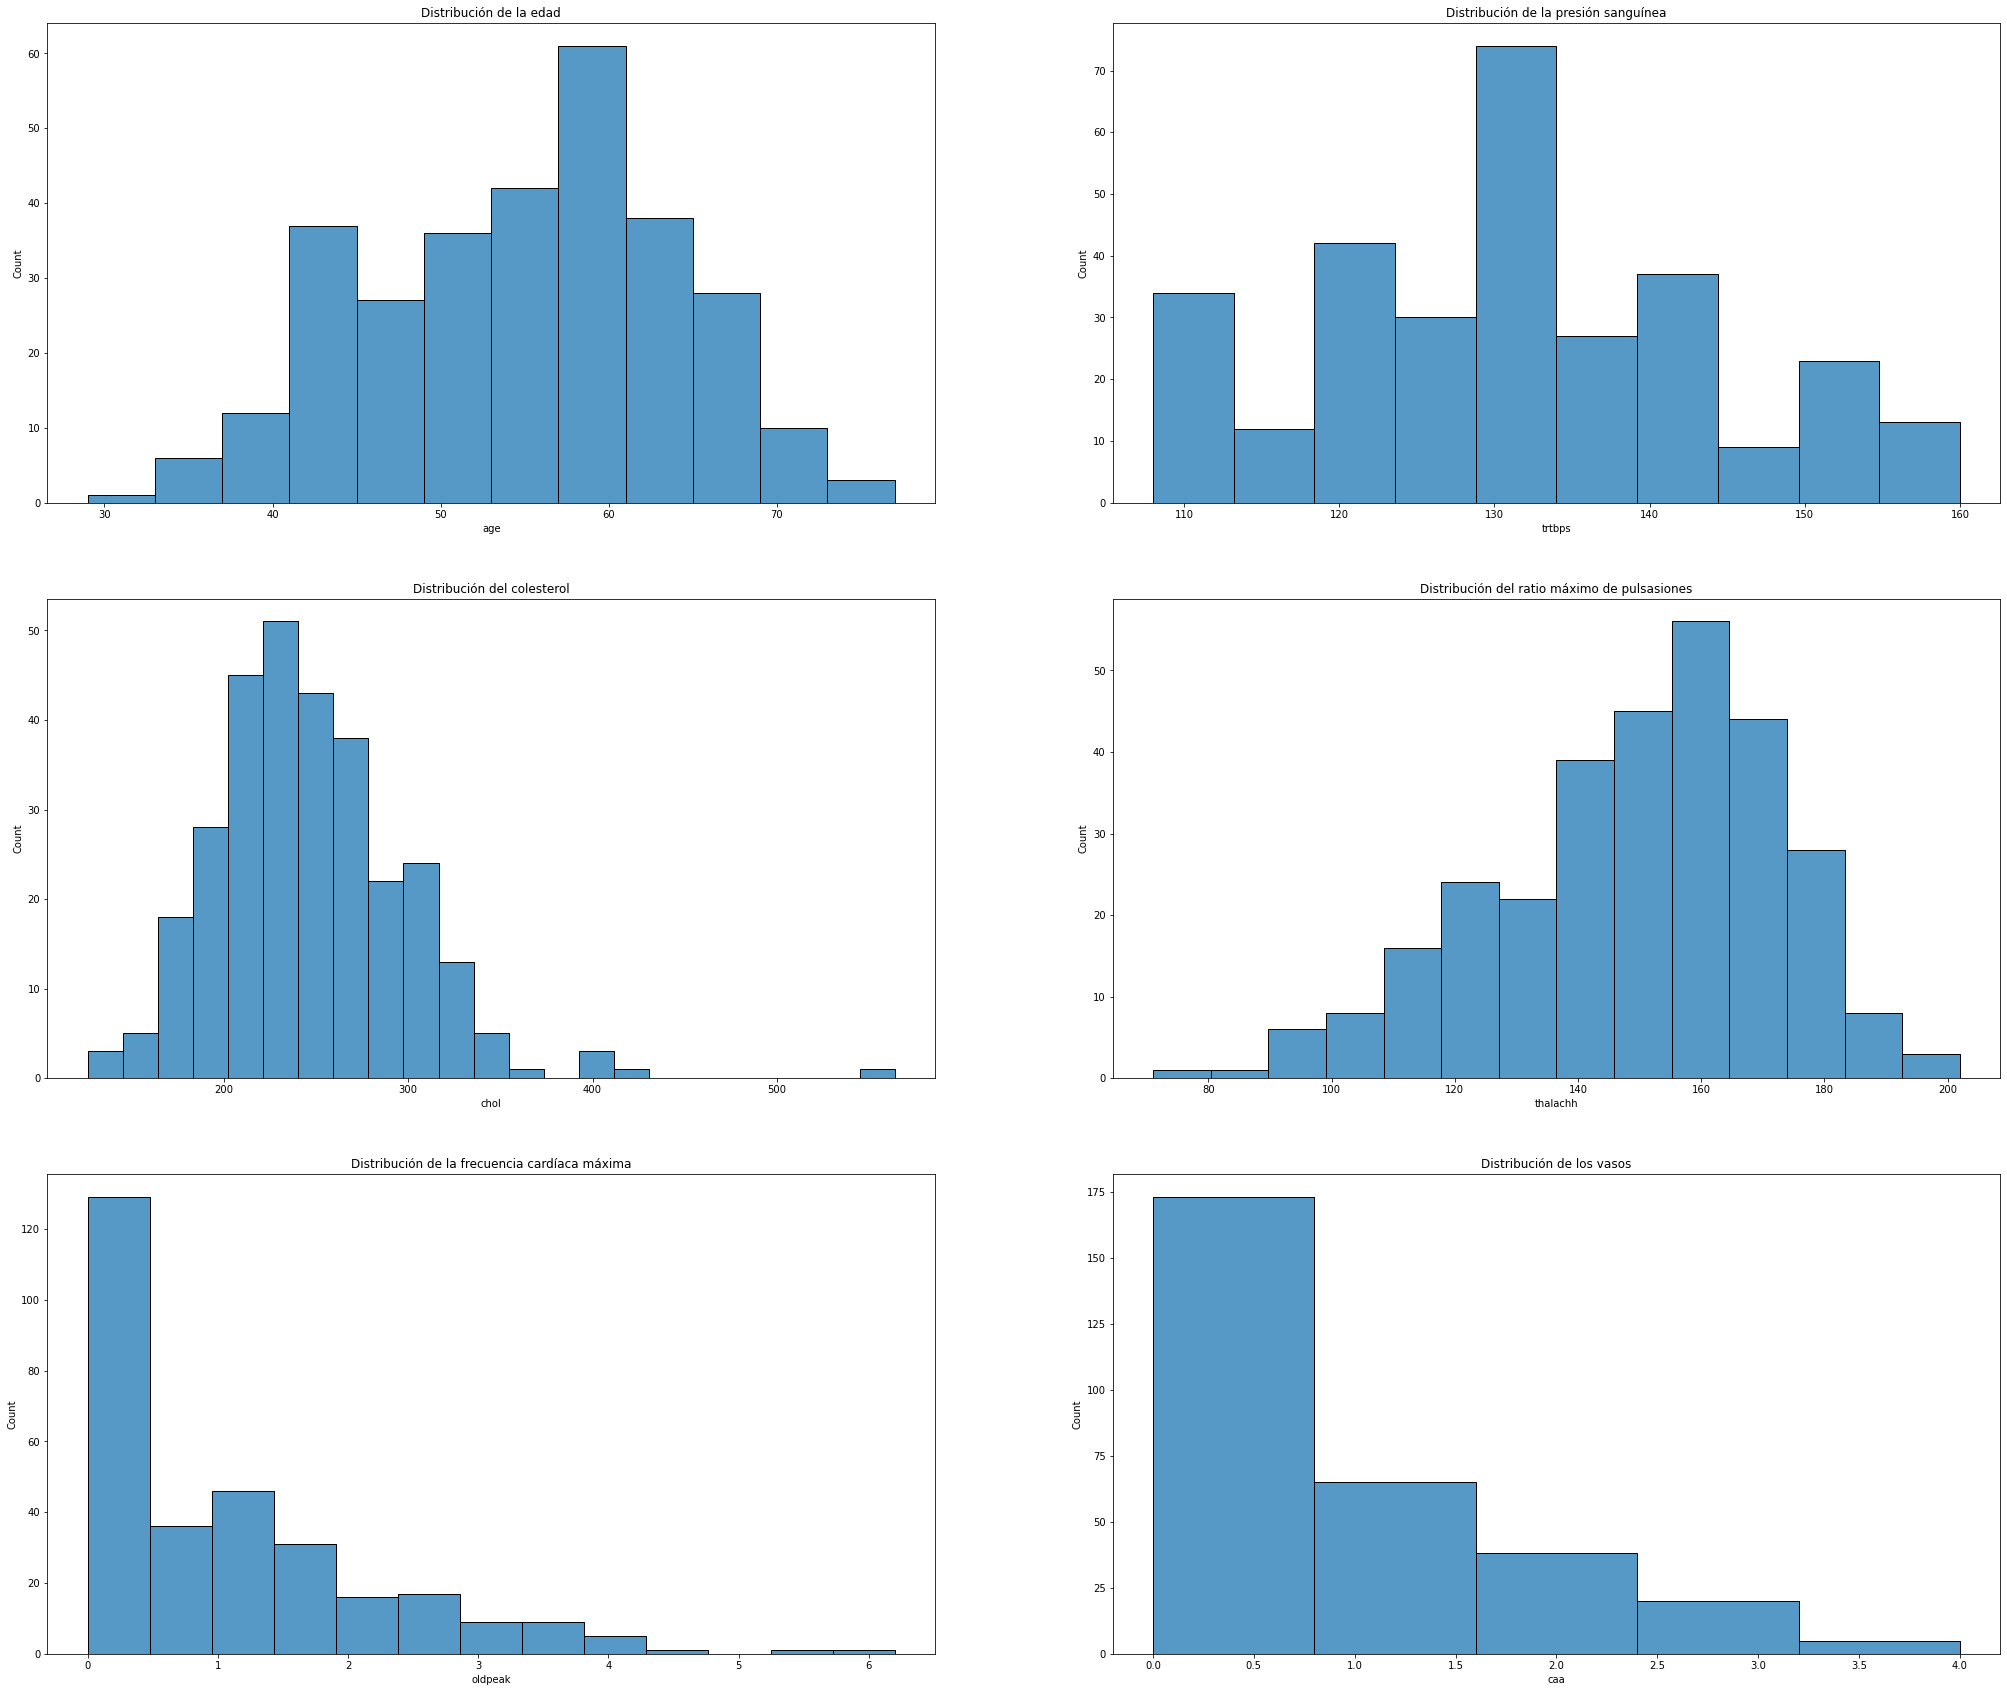

In [66]:
fig, axes = plt.subplots(3, 2, figsize=(35,30))

sns.histplot(ax=axes[0,0], x="age", palette="viridis", data=df).set(title='Distribución de la edad')
sns.histplot(ax=axes[0,1], x="trtbps", palette="viridis", data=df).set(title='Distribución de la presión sanguínea')

sns.histplot(ax=axes[1,0], x="chol" ,palette="viridis", data=df).set(title='Distribución del colesterol')
sns.histplot(ax=axes[1,1], x="thalachh" ,palette="viridis", data=df).set(title='Distribución del ratio máximo de pulsasiones')

sns.histplot(ax=axes[2,0], x="oldpeak" ,palette="viridis", data=df).set(title='Distribución de la frecuencia cardíaca máxima')
sns.histplot(ax=axes[2,1], x="caa" ,palette="viridis", data=df, bins=5).set(title='Distribución de los vasos')

plt.show()

Definimos la siguiente función para reemplazar aquellos valores que se encuentren por encima del percentil 95 o por debajo del percentil 5, considerados como valores extremos, por la mediana.

In [67]:
df.describe()

,age,trtbps,chol,thalachh,oldpeak,caa,output
count,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000
mean,54.378738,130.681063,246.504983,149.740864,1.043189,0.734219,0.544850
std,9.110950,12.712380,51.915998,22.891031,1.163384,1.024268,0.498814
min,29.000000,108.000000,126.000000,71.000000,0.000000,0.000000,0.000000
25%,47.000000,120.000000,211.000000,134.000000,0.000000,0.000000,0.000000
50%,56.000000,130.000000,241.000000,153.000000,0.800000,0.000000,1.000000
75%,61.000000,140.000000,275.000000,166.000000,1.600000,1.000000,1.000000
max,77.000000,160.000000,564.000000,202.000000,6.200000,4.000000,1.000000


In [62]:
def replaceOuliers(column):
    """
    """
    colReplace = np.array(column)
    median = np.median(column)
    
    upper =  np.percentile(np.array(column),95)
    lower =  np.percentile(np.array(column),5)
    
    colReplace[colReplace[:] > upper] = median
    colReplace[colReplace[:] < lower] = median
    return list(colReplace)

In [63]:
df["trtbps"] = replaceOuliers(list(df["trtbps"]))
df["chol"] = replaceOuliers(list(df["chol"]))



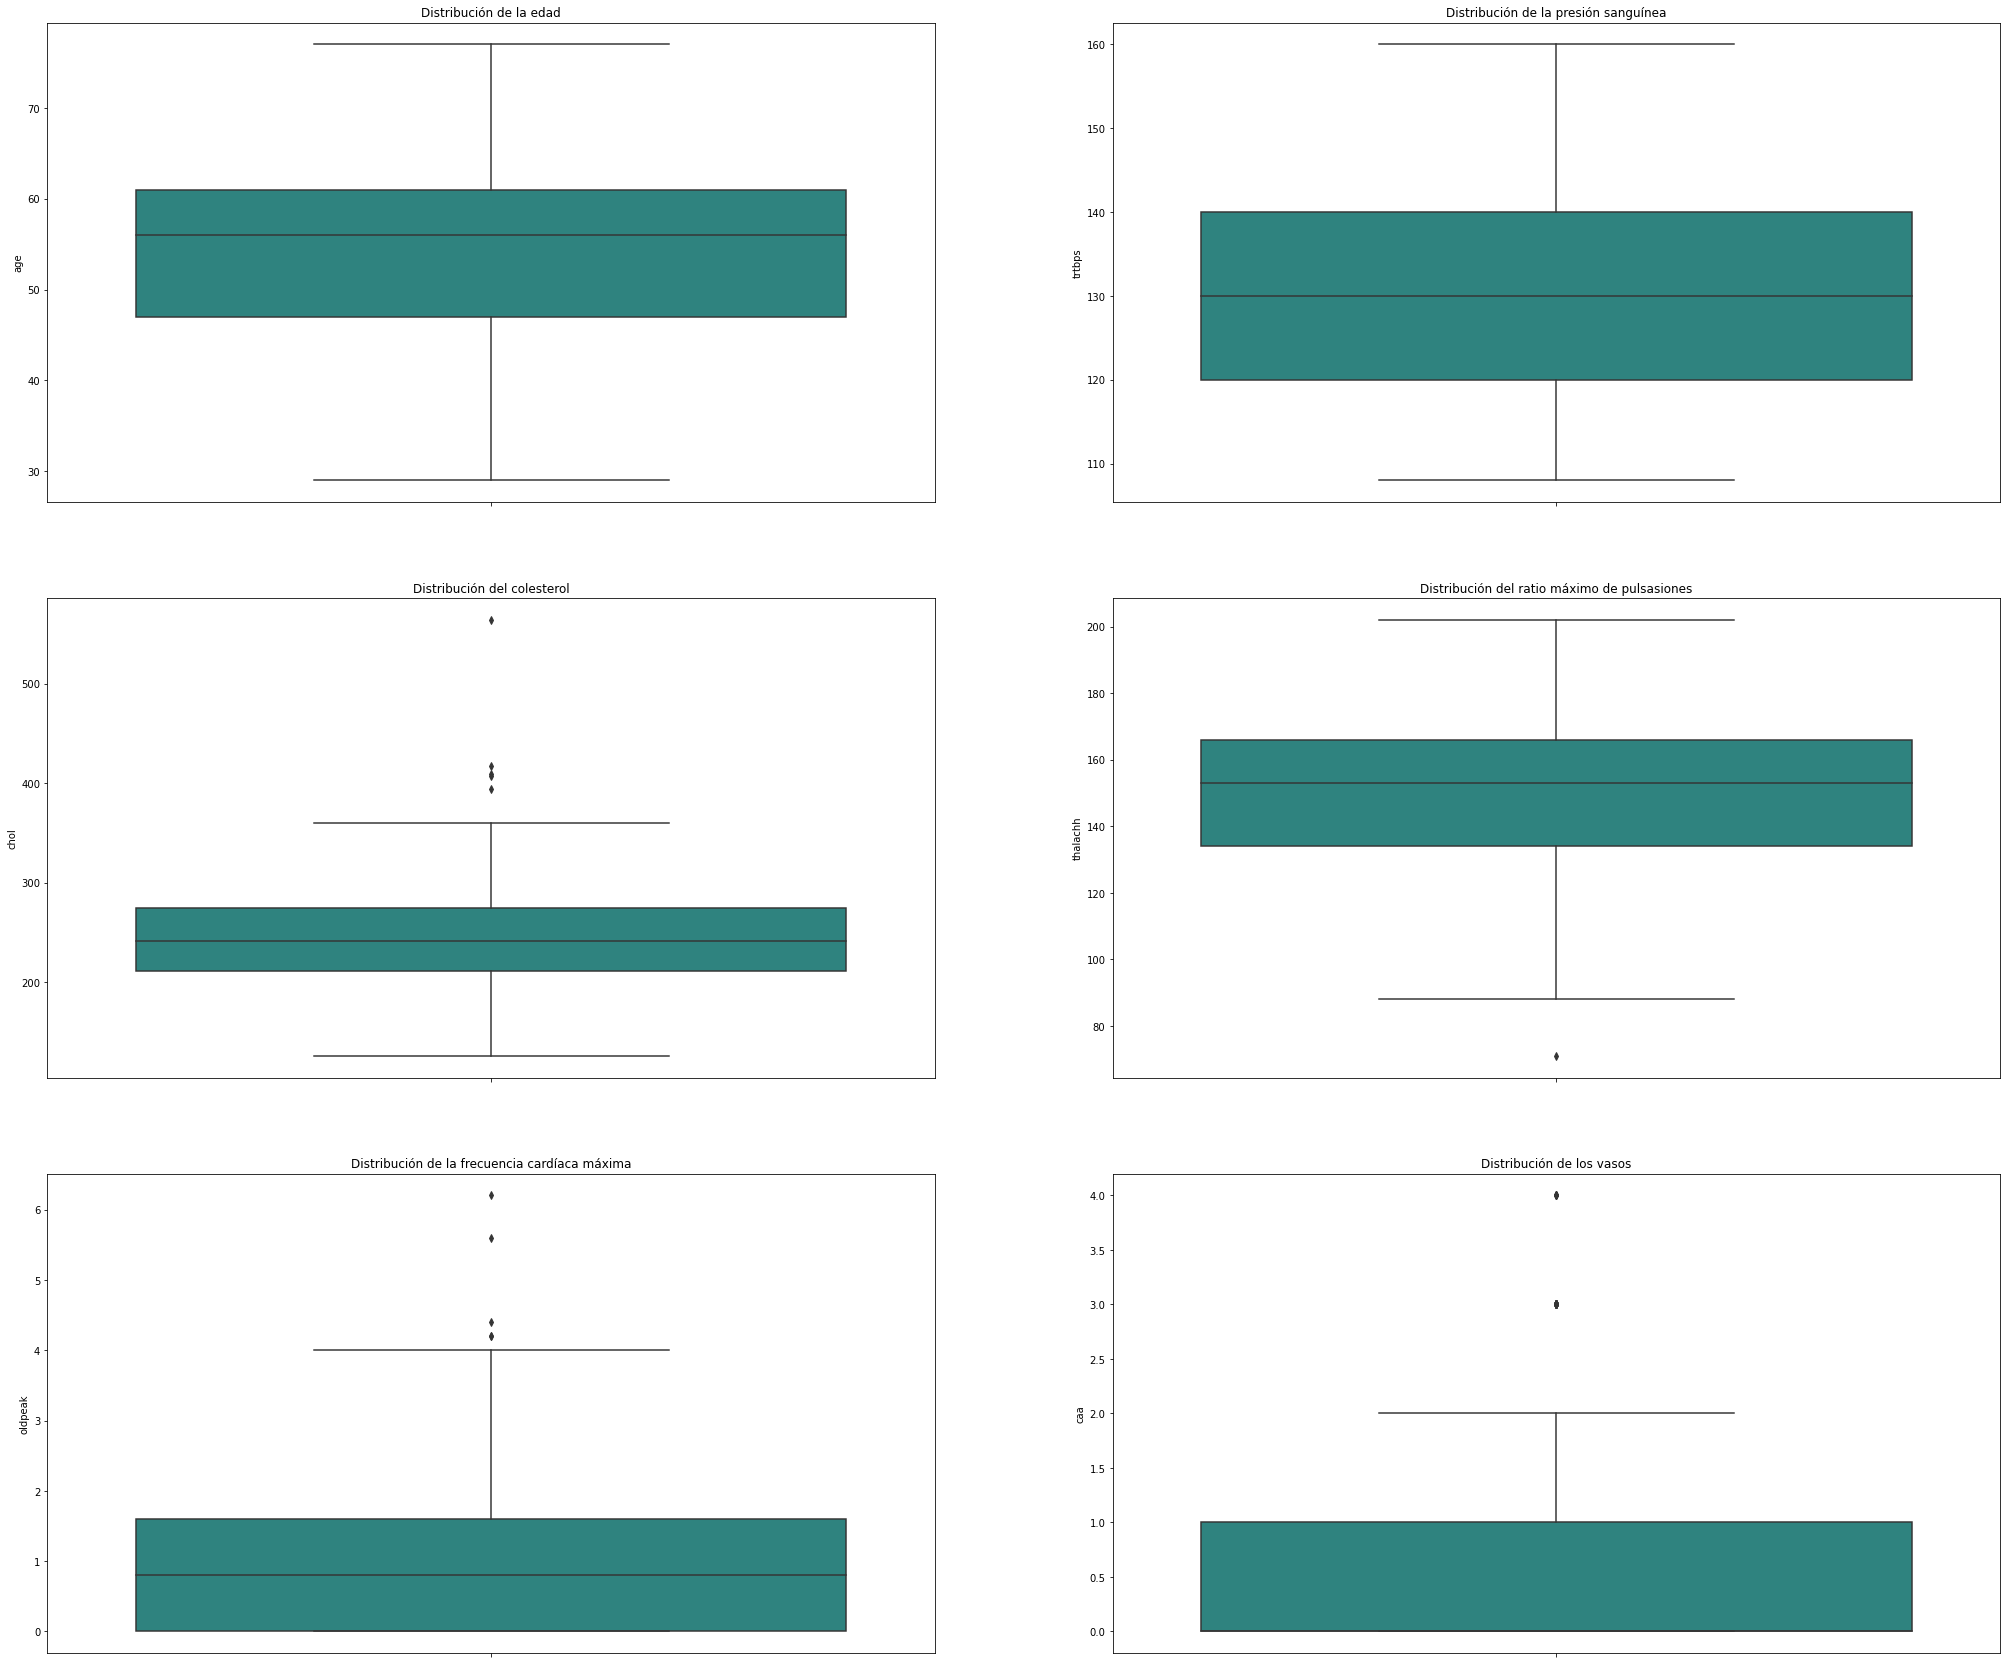

In [64]:
fig, axes = plt.subplots(3, 2, figsize=(35,30))

sns.boxplot(ax=axes[0,0], y="age", palette="viridis", data=df).set(title='Distribución de la edad')
sns.boxplot(ax=axes[0,1], y="trtbps", palette="viridis", data=df).set(title='Distribución de la presión sanguínea')

sns.boxplot(ax=axes[1,0], y="chol" ,palette="viridis", data=df).set(title='Distribución del colesterol')
sns.boxplot(ax=axes[1,1], y="thalachh" ,palette="viridis", data=df).set(title='Distribución del ratio máximo de pulsasiones')

sns.boxplot(ax=axes[2,0], y="oldpeak" ,palette="viridis", data=df).set(title='Distribución de la frecuencia cardíaca máxima')
sns.boxplot(ax=axes[2,1], y="caa" ,palette="viridis", data=df).set(title='Distribución de los vasos')

plt.show()

In [ ]:
y="trtbps", palette="viridis", data=df

Realizamos un análisis exploratorio de datos:


Revisamos los estadísticos descriptivos de las variables cuantitativas

In [ ]:
df.describe()

Analizamos los mismos estadísticos descriptivos pero esta vez haciendo distinción entre los grupos de enfermos y no enfermos del conjunto de datos

In [ ]:
df[["age","trtbps","chol","thalachh","oldpeak","caa","thall","output"]].groupby("output").describe().T

# 4. Análisis de los datos

### Análisis Exploratorio de datos

In [10]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,Male,atypical angina,145.0,233.0,fastingBloodSugar_true,Left ventricular hypertrophy,150.0,0.0,2.3,3.0,0.0,1.0,0
1,67.0,Male,typical angina,160.0,286.0,fastingBloodSugar_false,Left ventricular hypertrophy,108.0,1.0,1.5,2.0,3.0,0.0,1
2,67.0,Male,typical angina,120.0,229.0,fastingBloodSugar_false,Left ventricular hypertrophy,129.0,1.0,2.6,2.0,2.0,2.0,1
3,37.0,Male,asymptomatic,130.0,250.0,fastingBloodSugar_false,Normal,187.0,0.0,3.5,3.0,0.0,0.0,0
4,41.0,Female,non-anginal pain,130.0,204.0,fastingBloodSugar_false,Left ventricular hypertrophy,172.0,0.0,1.4,1.0,0.0,0.0,0


A continuación se presentan las distribuciones de las variables en función del target o variable a predecir

### Age

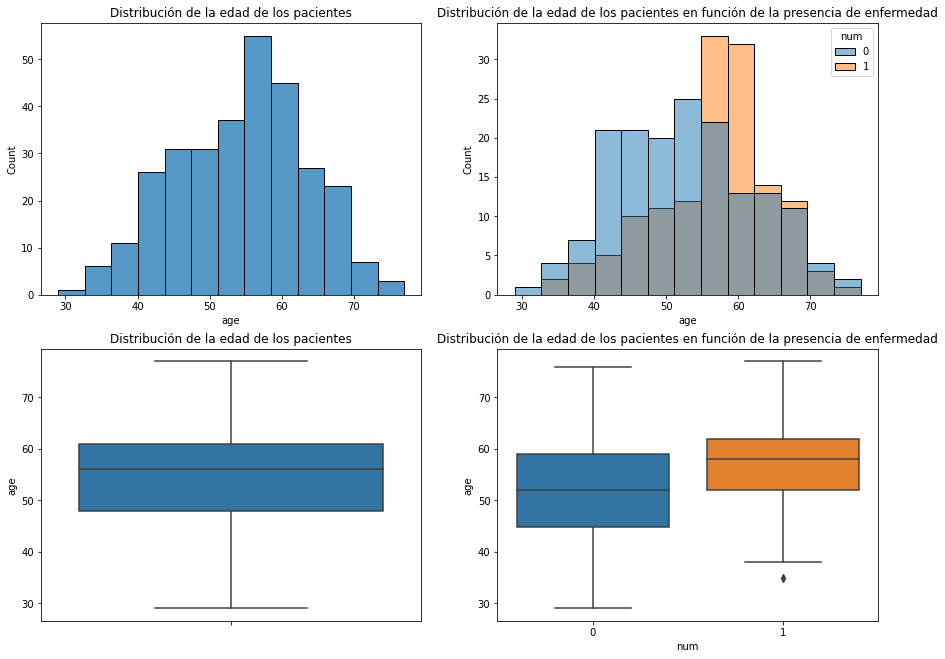

In [59]:
fig, axes = plt.subplots(2, 2, figsize=(15,11))

sns.histplot(x=df["age"], ax=axes[0,0]).set(title='Distribución de la edad de los pacientes')
sns.histplot(x=df["age"], hue=df["num"], ax=axes[0,1]).set(title='Distribución de la edad de los pacientes en función de la presencia de enfermedad')

sns.boxplot(y=df["age"], ax=axes[1,0]).set(title='Distribución de la edad de los pacientes')
sns.boxplot(y=df["age"], x=df["num"], ax=axes[1,1]).set(title='Distribución de la edad de los pacientes en función de la presencia de enfermedad')

plt.show()

In [41]:
df[["age","num"]].groupby("num").describe().T

num                 0           1
age count  164.000000  139.000000
    mean    52.585366   56.625899
    std      9.511957    7.938416
    min     29.000000   35.000000
    25%     44.750000   52.000000
    50%     52.000000   58.000000
    75%     59.000000   62.000000
    max     76.000000   77.000000

Se puede observar comparando las distribuciones, que la mediana y el promedio de la edad de las personas que enferman es mayor que las personas sanas. 

### Sex

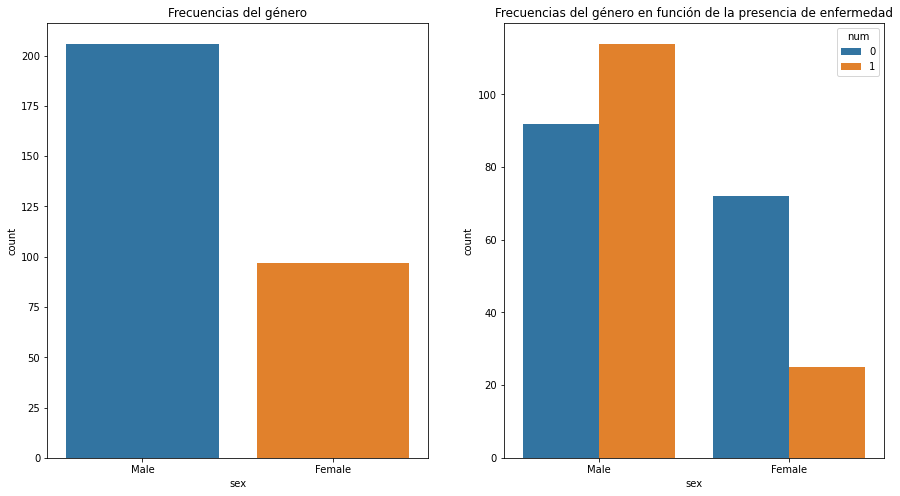

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(15,8))

sns.countplot(x=df["sex"], ax=axes[0]).set(title='Frecuencias del género')

sns.countplot(x=df["sex"], hue=df["num"], ax=axes[1]).set(title='Frecuencias del género en función de la presencia de enfermedad')

plt.show()

In [45]:
pd.crosstab(index= df["sex"], columns=df["num"], normalize=True)

num,0,1
sex,,
Female,0.237624,0.082508
Male,0.303630,0.376238


Se observa que la proporción de mujeres que enferman es baja dentro de la muestra estudiada

### CP

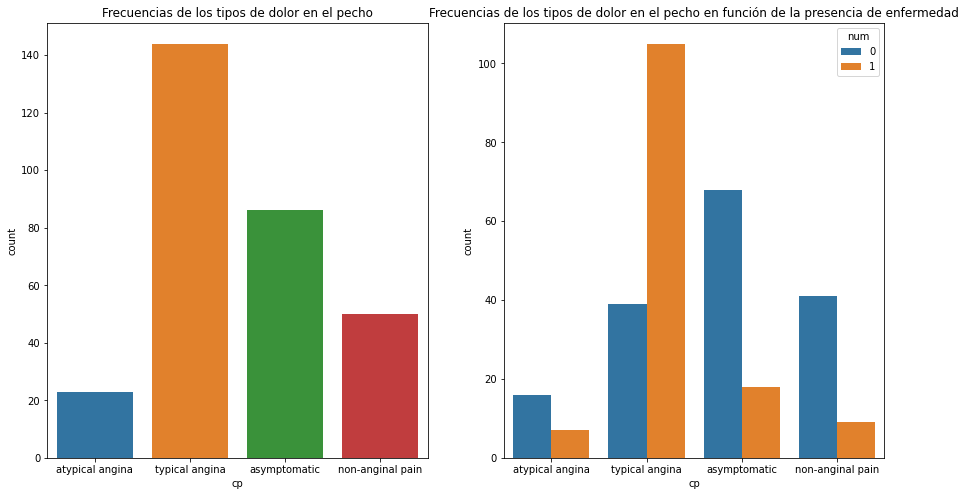

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(15,8))

sns.countplot(x=df["cp"], ax=axes[0]).set(title='Frecuencias de los tipos de dolor en el pecho')

sns.countplot(x=df["cp"], hue=df["num"], ax=axes[1]).set(title='Frecuencias de los tipos de dolor en el pecho en función de la presencia de enfermedad')

plt.show()

In [49]:
pd.crosstab(index= df["cp"], columns=df["num"], normalize=True)

num,0,1
cp,,
asymptomatic,0.224422,0.059406
atypical angina,0.052805,0.023102
non-anginal pain,0.135314,0.029703
typical angina,0.128713,0.346535


La angina típica para ser el tipo de dolor más asociado a la presencia de la enfermedad

### trestbps

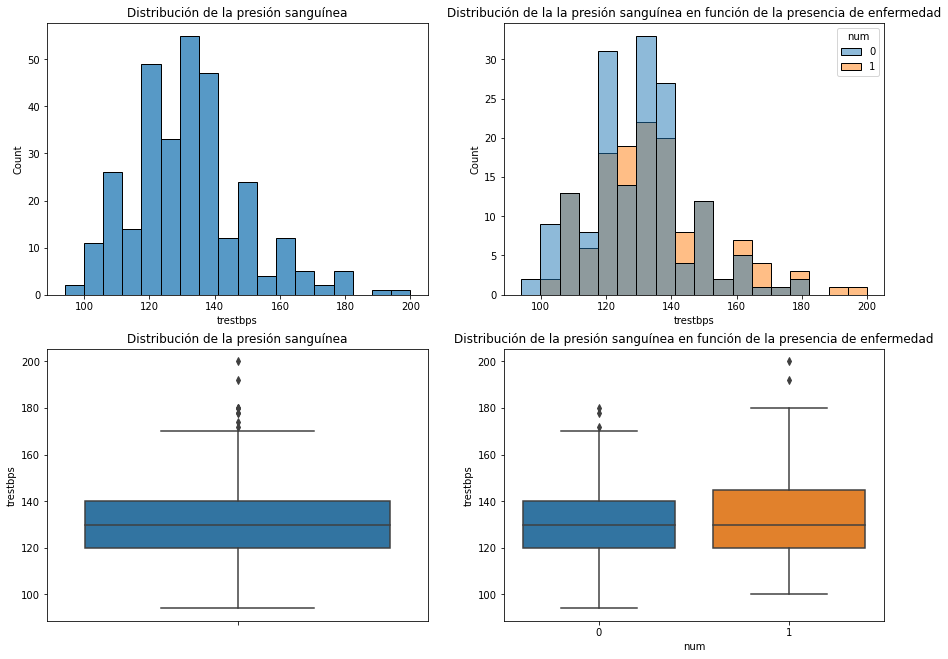

In [58]:
fig, axes = plt.subplots(2, 2, figsize=(15,11))

sns.histplot(x=df["trestbps"], ax=axes[0,0]).set(title='Distribución de la presión sanguínea')
sns.histplot(x=df["trestbps"], hue=df["num"], ax=axes[0,1]).set(title='Distribución de la la presión sanguínea en función de la presencia de enfermedad')

sns.boxplot(y=df["trestbps"], ax=axes[1,0]).set(title='Distribución de la presión sanguínea')
sns.boxplot(y=df["trestbps"], x=df["num"], ax=axes[1,1]).set(title='Distribución de la presión sanguínea en función de la presencia de enfermedad')

plt.show()

In [54]:
df[["trestbps","num"]].groupby("num").describe().T

num                      0           1
trestbps count  164.000000  139.000000
         mean   129.250000  134.568345
         std     16.204739   18.769019
         min     94.000000  100.000000
         25%    120.000000  120.000000
         50%    130.000000  130.000000
         75%    140.000000  145.000000
         max    180.000000  200.000000

Parece no haber grandes diferencias en los estadísticos de tendencia central en las distribuciones de las presión sanguínea entre personas enfermas y sanas

### Chol

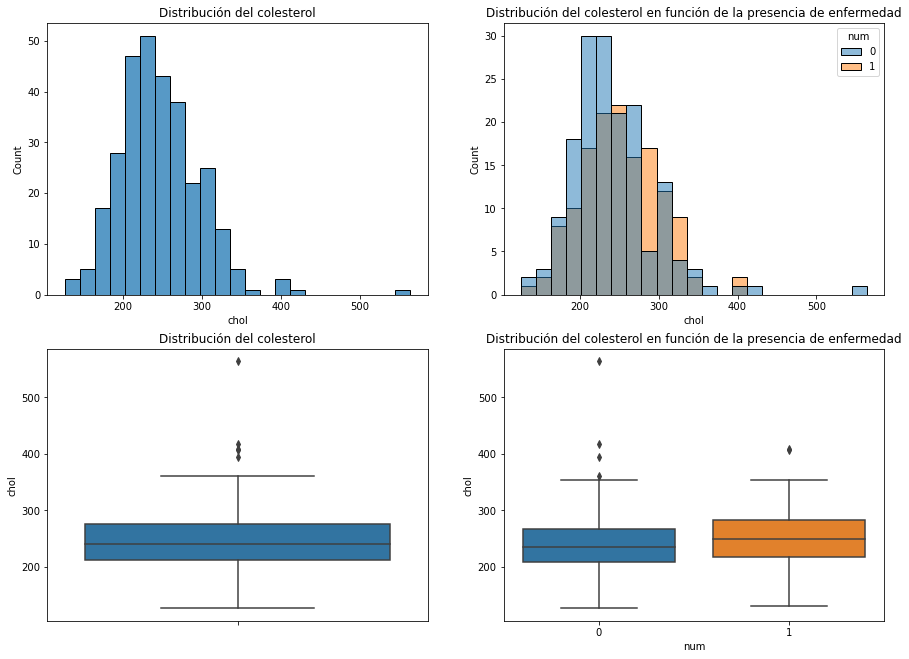

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(15,11))

sns.histplot(x=df["chol"], ax=axes[0,0]).set(title='Distribución del colesterol')
sns.histplot(x=df["chol"], hue=df["num"], ax=axes[0,1]).set(title='Distribución del colesterol en función de la presencia de enfermedad')

sns.boxplot(y=df["chol"], ax=axes[1,0]).set(title='Distribución del colesterol')
sns.boxplot(y=df["chol"], x=df["num"], ax=axes[1,1]).set(title='Distribución del colesterol en función de la presencia de enfermedad')

plt.show()

In [60]:
df[["chol","num"]].groupby("num").describe().T

num                  0           1
chol count  164.000000  139.000000
     mean   242.640244  251.474820
     std     53.456580   49.486835
     min    126.000000  131.000000
     25%    208.750000  217.500000
     50%    234.500000  249.000000
     75%    267.250000  283.500000
     max    564.000000  409.000000

El nivel de colesterol, en promedio, es más elevado en las personas que presentan la enfermedad

### fbs

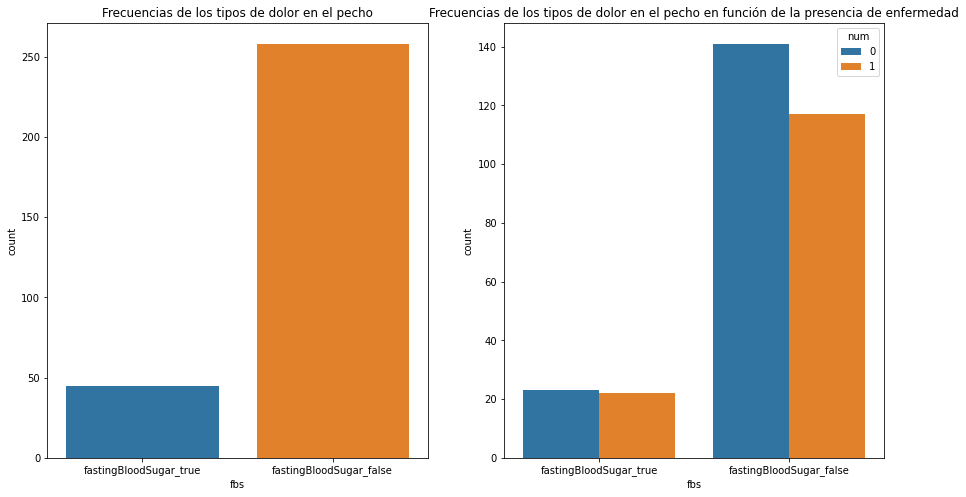

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(15,8))

sns.countplot(x=df["fbs"], ax=axes[0]).set(title='Frecuencias de los tipos de dolor en el pecho')

sns.countplot(x=df["fbs"], hue=df["num"], ax=axes[1]).set(title='Frecuencias de los tipos de dolor en el pecho en función de la presencia de enfermedad')

plt.show()

In [63]:
pd.crosstab(index= df["fbs"], columns=df["num"], normalize=True)

num,0,1
fbs,,
fastingBloodSugar_false,0.465347,0.386139
fastingBloodSugar_true,0.075908,0.072607


### restecg

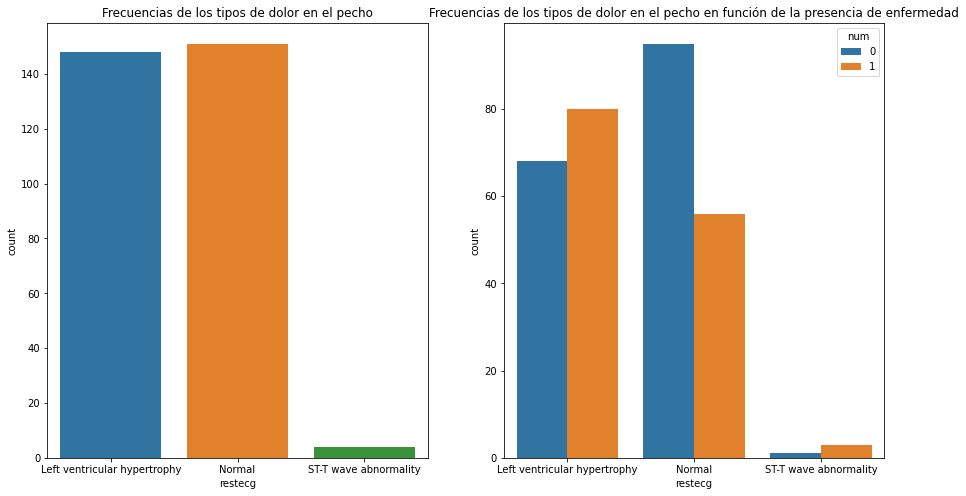

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(15,8))

sns.countplot(x=df["restecg"], ax=axes[0]).set(title='Frecuencias de los tipos de dolor en el pecho')

sns.countplot(x=df["restecg"], hue=df["num"], ax=axes[1]).set(title='Frecuencias de los tipos de dolor en el pecho en función de la presencia de enfermedad')

plt.show()

In [65]:
pd.crosstab(index= df["restecg"], columns=df["num"], normalize=True)

num,0,1
restecg,,
Left ventricular hypertrophy,0.224422,0.264026
Normal,0.313531,0.184818
ST-T wave abnormality,0.003300,0.009901


### thalach

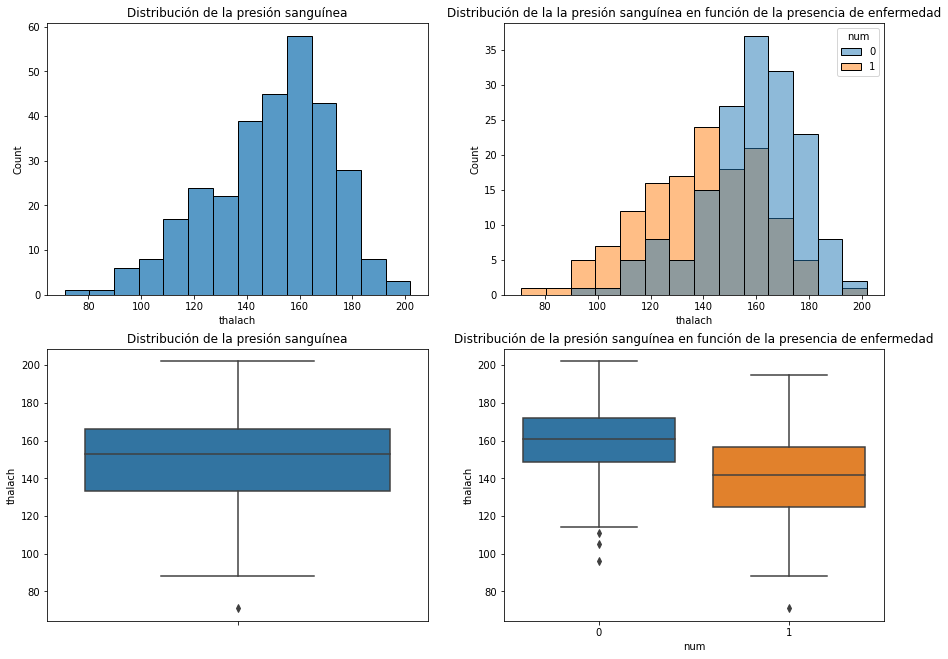

In [66]:
fig, axes = plt.subplots(2, 2, figsize=(15,11))

sns.histplot(x=df["thalach"], ax=axes[0,0]).set(title='Distribución de la presión sanguínea')
sns.histplot(x=df["thalach"], hue=df["num"], ax=axes[0,1]).set(title='Distribución de la la presión sanguínea en función de la presencia de enfermedad')

sns.boxplot(y=df["thalach"], ax=axes[1,0]).set(title='Distribución de la presión sanguínea')
sns.boxplot(y=df["thalach"], x=df["num"], ax=axes[1,1]).set(title='Distribución de la presión sanguínea en función de la presencia de enfermedad')

plt.show()

In [50]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,Male,atypical angina,145.0,233.0,fastingBloodSugar_true,Left ventricular hypertrophy,150.0,0.0,2.3,3.0,0.0,1.0,0
1,67.0,Male,typical angina,160.0,286.0,fastingBloodSugar_false,Left ventricular hypertrophy,108.0,1.0,1.5,2.0,3.0,0.0,1
2,67.0,Male,typical angina,120.0,229.0,fastingBloodSugar_false,Left ventricular hypertrophy,129.0,1.0,2.6,2.0,2.0,2.0,1
3,37.0,Male,asymptomatic,130.0,250.0,fastingBloodSugar_false,Normal,187.0,0.0,3.5,3.0,0.0,0.0,0
4,41.0,Female,non-anginal pain,130.0,204.0,fastingBloodSugar_false,Left ventricular hypertrophy,172.0,0.0,1.4,1.0,0.0,0.0,0


## 4.1. Selección de los grupos de datos que se quieren analizar/comparar 
**(p.ej., si se van a comparar grupos de datos, ¿cuáles son estos grupos y
qué tipo de análisis se van a aplicar?)**

A lo largo de la presente investigación se van a comparar los grupos de pacientes enfermos y pacientes sanos

## 4.2. Comprobación de la normalidad y homogeneidad de la varianza

Definimos una función para realizar los contrastes de homogenidad de varianza de forma más efectiva:

In [72]:
def testLevene(listA, listB):
    """
    listA: list type to compare variance 
    listB: list type to compare variance
    
    """
    
    a = np.array(listA)
    b = np.array(listB)
    stat, p = levene(a, b)
    
    if p < 0.05:
        print("Variances not equal, p value: {}".format(p))
    else:
        print("Variances equal, p value: {}".format(p))
    
    

Separamos los datos en enfermos y sanos para facilitar los contrastes:

In [73]:
df_sick = df[df["num"] == 1] 
df_healthy = df[df["num"] == 0] 

### Age

In [74]:
testLevene(df_sick["age"], df_healthy["age"])

Variances not equal, p value: 0.0051667349340750405


### trestbps

In [75]:
testLevene(df_sick["trestbps"], df_healthy["trestbps"])

Variances equal, p value: 0.15831196426971206


### chol

In [76]:
testLevene(df_sick["chol"], df_healthy["chol"])

Variances equal, p value: 0.7032231637527186


### thalach

In [77]:
testLevene(df_sick["thalach"], df_healthy["thalach"])

Variances not equal, p value: 0.022996018094294857


## 4.3. Aplicación de pruebas estadísticas para comparar los grupos de datos
**En función de los datos y el objetivo del estudio, aplicar pruebas de contraste de hipótesis, correlaciones, regresiones, etc. Aplicar al menos tres métodos de análisis diferentes.**



## 4.4. Relación entre predictores


In [82]:
df[["age","trestbps","chol","thalach","ca"]].corr()

,age,trestbps,chol,thalach,ca
age,1.000000,0.284946,0.208950,-0.393806,0.362605
trestbps,0.284946,1.000000,0.130120,-0.045351,0.098773
chol,0.208950,0.130120,1.000000,-0.003432,0.119000
thalach,-0.393806,-0.045351,-0.003432,1.000000,-0.264246
ca,0.362605,0.098773,0.119000,-0.264246,1.000000


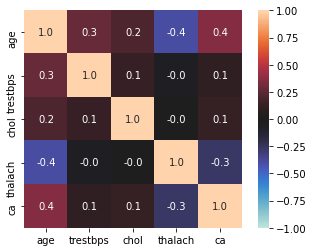

In [80]:
sns.heatmap(df[["age","trestbps","chol","thalach","ca"]].corr(),
            vmin=-1, vmax=1, center=0,
            square=True,
            annot=True,
            fmt=".1f"
           )
plt.show()

## 4.4. Modelaje Estadístico

Elegimos probar principalmente 3 clasificadores:

In [ ]:
logistcRegresion = LogisticRegression()
decisionTree = DecisionTreeClassifier()
randomForest = RandomForestClassifier()

Definimos estos parámetros para hacer grid search

In [ ]:
############### LR
logistcRegresion_params = {'C': [0.01,0.1,1,10,100,1000]}

############### DT

decisionTree_params = {"criterion":["gini","entropy"],
                       "max_depth":[5,10,20]    
                      }

############### RF
randomForest_params = {
    'max_depth': [5,10,20],
    "criterion":["gini","entropy"],
    'max_features': ['auto'],
    'n_estimators': [10,80],
    'n_jobs':[-1]
    
}


Separamos en X e Y

In [ ]:
model_GS = GridSearchCV(estimator=model,
                             param_grid=param, 
                             scoring = ['accuracy', 'f1','balanced_accuracy','roc_auc'],
                             n_jobs=-1,
                             cv=5,
                             verbose=False,
                             refit='f1'
                            )
        
model_GS.fit(X,y)
estimator = model_GS.best_estimator_
dump(estimator, str("models/" + modelN + "_" + data[i][0] + "_" + ".joblib"))

In [ ]:
results = pd.DataFrame(model_GS.cv_results_)

# 5. Representación gráfica
**Representación de los resultados a partir de tablas y gráficas. Este apartado se puede responder a lo largo de la práctica, sin necesidad de concentrar todas las representaciones en este punto de la práctica.**

xxx Resuelto a lo largo de la práctica xx

# 6. Resolución del problema
**A partir de los resultados obtenidos, ¿cuáles son las conclusiones? ¿Los resultados permiten responder al problema?**

# 7. Código
**Hay que adjuntar el código, preferiblemente en R, con el que se ha realizado la limpieza, análisis y representación de los datos. Si lo preferís, también podéis trabajar en Python.**

xx El código se ha ido viendo a lo largo de la práctica xx

# 8. Vídeo
**Realizar un breve vídeo explicativo de la práctica (máximo 10 minutos), donde ambos integrantes del equipo expliquen con sus propias palabras el desarrollo de la práctica, basándose en las preguntas del enunciado para justificar y explicar el código desarrollado. Este vídeo se deberá entregar a través de un enlace al Google Drive de la UOC (https://drive.google.com/...), junto con enlace al repositorio Git entregado.**

# Contribuciones

In [5]:
contribuciones = pd.DataFrame()
contribuciones['Contribuciones'] = ['Investigación previa', 'Redacción de las respuestas', 'Desarrollo del código', 'Participación en el vídeo']
contribuciones['Firma'] = ['Víctor H. Ayala, Clara Roca', 'Víctor H. Ayala, Clara Roca', 'Víctor H. Ayala, Clara Roca', 'Víctor H. Ayala, Clara Roca']
contribuciones

,Contribuciones,Firma
0,Investigación previa,"Víctor H. Ayala, Clara Roca"
1,Redacción de las respuestas,"Víctor H. Ayala, Clara Roca"
2,Desarrollo del código,"Víctor H. Ayala, Clara Roca"
3,Participación en el vídeo,"Víctor H. Ayala, Clara Roca"


***